In [1]:
!pip install matplotlib seaborn

In [2]:
import pandas as pd 
import numpy as np 
import random
from collections import defaultdict, Counter
import re

In [3]:
import matplotlib.pyplot as plt 
import seaborn as sns 

sns.set()

In [4]:
import torch 
from torch import nn 
from torch.nn import CrossEntropyLoss
from torch.utils.data import Dataset, DataLoader 
from torch.optim import Adam
from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModelForPreTraining
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from datasets import Dataset, DatasetDict, load_metric
import torch.nn.functional as F

## Константы

In [5]:
label_list = ['B-LOC', 'I-LOC', 'B-ORG', 'I-ORG', 'B-PER', 'I-PER', 'B-FAC', 'I-FAC', 'B-CHAR', 'I-CHAR', 'O']

bio2num = {
    'B-LOC': 0, 
    'I-LOC': 1, 
    'B-ORG': 2, 
    'I-ORG': 3, 
    'B-PER': 4, 
    'I-PER': 5, 
    'B-FAC': 6, 
    'I-FAC': 7, 
    'B-CHAR': 8, 
    'I-CHAR': 9, 
    'O': 10 
}

MODEL_PATH = 'rubert-factru-finetuned/checkpoint-3950'
OUTPUT_DIR = '.'
res = {} 

In [6]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [7]:
set_random_seed(42)

## Загружаем данные 

### FactRu

In [8]:
def preprocess_labels(labels): 
    nums = labels.split(', ')
    nums[0] = nums[0][1:] 
    nums[-1] = nums[-1][:-1]

    return list(map(int, nums))

In [9]:
def preprocess_bio(bio): 
    bios = bio.split(', ') 
    bios[0] = bios[0][1:] 
    bios[-1] = bios[-1][:-1] 
    for i, x in enumerate(bios): 
        bios[i] = x[1:-1]

    return list(bios)

def bio_to_num(bios): 
    ans = []
    for bio in bios: 
        ans.append(bio2num[bio])

    return ans

In [10]:
df_test_factru = pd.read_csv('data/factru_test.csv')

df_test_factru['BIO'] = df_test_factru['BIO'].apply(lambda x: preprocess_bio(x)) 
df_test_factru['BIO_nums'] = df_test_factru['BIO'].apply(lambda x: bio_to_num(x))
df_test_factru.head()

,tokens,BIO,BIO_nums
0,"['Всё', 'это', 'время', 'я', 'просидел', 'в', ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1..."
1,"['Завод', ',', 'занимающий', 'лидирующие', 'по...","[O, O, O, O, O, O, O, O, O, O, B-LOC, O, O, O,...","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10..."
2,"['""', ',', '""', 'Пока', 'все', 'дома', '""', ',...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1..."
3,"['Мы', 'не', 'жалеем', 'никого', '.']","[O, O, O, O, O]","[10, 10, 10, 10, 10]"
4,"['«', 'Если', 'региону', 'необходимо', 'погаси...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1..."


### Размечено 

In [11]:
df_train_razmecheno = pd.read_csv('prozhito_data/df_train_prozhito.csv')
df_test_razmecheno = pd.read_csv('prozhito_data/df_test_prozhito.csv')
df_val_razmecheno = pd.read_csv('prozhito_data/df_val_prozhito.csv')

df_train_razmecheno['BIO_nums'] = df_train_razmecheno['BIO_nums'].apply(lambda x: preprocess_labels(x)) 
df_test_razmecheno['BIO_nums'] = df_test_razmecheno['BIO_nums'].apply(lambda x: preprocess_labels(x)) 
df_val_razmecheno['BIO_nums'] = df_val_razmecheno['BIO_nums'].apply(lambda x: preprocess_labels(x)) 

df_train_razmecheno.head()

,Unnamed: 0,tokens,BIO_str,BIO_nums,BIO_list
0,0,У меня большая симпатия к Лукьянину — человек ...,O O O O O O O O O O O O O O O O O O O O O,"[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
1,2,"> Каким приговором , указом каким > Ты здесь ,...",O O O O O O O O O O O O O O O O O,"[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
2,3,"Подумал , что летом ребята куда затащили .",O O O O B-CHAR O O O,"[10, 10, 10, 10, 8, 10, 10, 10]","['O', 'O', 'O', 'O', 'B-CHAR', 'O', 'O', 'O']"
3,4,Нашел потрясающие материалы о В . М . Брадисе ...,O O O O B-PER I-PER I-PER I-PER I-PER O O B-CH...,"[10, 10, 10, 10, 4, 5, 5, 5, 5, 10, 10, 8, 8, ...","['O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'I-PER'..."
4,5,[Без даты . ],O O O O,"[10, 10, 10, 10]","['O', 'O', 'O', 'O']"


In [12]:
df_train_razmecheno['length'] = df_train_razmecheno['BIO_nums'].apply(lambda x: len(x))
df_test_razmecheno['length'] = df_test_razmecheno['BIO_nums'].apply(lambda x: len(x))
df_val_razmecheno['length'] = df_val_razmecheno['BIO_nums'].apply(lambda x: len(x))
df_test_factru['length'] = df_test_factru['BIO_nums'].apply(lambda x: len(x)) 

## Подготовка датасета

In [13]:
data = DatasetDict({
    'razmecheno_train': Dataset.from_pandas(df_train_razmecheno[['tokens', 'BIO_nums', 'length']]),
    'razmecheno_test': Dataset.from_pandas(df_test_razmecheno[['tokens', 'BIO_nums', 'length']]),
    'razmecheno_val': Dataset.from_pandas(df_val_razmecheno[['tokens', 'BIO_nums', 'length']]), 
    'factru_test': Dataset.from_pandas(df_test_factru[['tokens', 'BIO_nums', 'length']])
})

data

DatasetDict({
    razmecheno_train: Dataset({
        features: ['tokens', 'BIO_nums', 'length'],
        num_rows: 1258
    })
    razmecheno_test: Dataset({
        features: ['tokens', 'BIO_nums', 'length'],
        num_rows: 273
    })
    razmecheno_val: Dataset({
        features: ['tokens', 'BIO_nums', 'length'],
        num_rows: 147
    })
    factru_test: Dataset({
        features: ['tokens', 'BIO_nums', 'length'],
        num_rows: 907
    })
})

In [14]:
def tokenizer_and_align(texts): 
    tokenized_input = tokenizer(texts['tokens'], truncation=True)
    print(tokenized_input.keys())

    labels = []
    for i, label in enumerate(texts['BIO_nums']): 
        word_ids = tokenized_input.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids: 
            if word_idx is None: 
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                if word_idx > len(label) - 1: 
                    label_ids.append(len(label_list) - 1)
                else: 
                    label_ids.append(label[word_idx])
            else: 
                if word_idx > len(label) - 1: 
                    label_ids.append(len(label_list) - 1)
                else:
                    label_ids.append(label[previous_word_idx])

            previous_word_idx = word_idx
            

        label_ids = [label_list.index(idx) if isinstance(idx, str) else idx for idx in label_ids]
        labels.append(label_ids)

    tokenized_input['labels'] = labels 
    return tokenized_input 

In [15]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH, model_max_length=512)

In [16]:
tokenized_datasets = data.map(tokenizer_and_align, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns('tokens')

  0%|          | 0/2 [00:00<?, ?ba/s]

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


  0%|          | 0/1 [00:00<?, ?ba/s]

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


  0%|          | 0/1 [00:00<?, ?ba/s]

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


  0%|          | 0/1 [00:00<?, ?ba/s]

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


### Сортировка по длине батча

In [17]:
tokenized_datasets = tokenized_datasets.sort('length')

In [18]:
tokenized_datasets = tokenized_datasets.remove_columns('length')
tokenized_datasets

DatasetDict({
    razmecheno_train: Dataset({
        features: ['BIO_nums', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1258
    })
    razmecheno_test: Dataset({
        features: ['BIO_nums', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 273
    })
    razmecheno_val: Dataset({
        features: ['BIO_nums', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 147
    })
    factru_test: Dataset({
        features: ['BIO_nums', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 907
    })
})

## Обучение

In [19]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

model = AutoModelForTokenClassification.from_pretrained(MODEL_PATH, num_labels=len(bio2num))
model.config.id2label = dict(enumerate(list(bio2num.keys())))
model.config.label2id = {v: k for k, v in model.config.id2label.items()}

In [20]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer)

In [21]:
metric = load_metric("seqeval")

In [22]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels, zero_division=0)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [23]:
def train(model, train_size): 
    model = AutoModelForTokenClassification.from_pretrained(MODEL_PATH, num_labels=len(label_list))
    model.config.id2label = dict(enumerate(label_list))
    model.config.label2id = {v: k for k, v in model.config.id2label.items()}

    args = TrainingArguments(
        "rubert-factru-prozhito-finetuned",
        evaluation_strategy = "epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=7,
        weight_decay=1e-4,
        report_to='none',
        save_strategy='no', 
    )
    if train_size < 1: 
        trainer = Trainer(
            model,
            args,
            train_dataset=tokenized_datasets['razmecheno_train'].train_test_split(train_size=train_size, seed=42)['train'],
            eval_dataset=tokenized_datasets['razmecheno_val'],
            data_collator=data_collator,
            tokenizer=tokenizer,
            compute_metrics=compute_metrics
        )
        
    else: 
        trainer = Trainer(
            model,
            args,
            train_dataset=tokenized_datasets['razmecheno_train'],
            eval_dataset=tokenized_datasets['razmecheno_val'],
            data_collator=data_collator,
            tokenizer=tokenizer,
            compute_metrics=compute_metrics
        )
        

    for param in model.parameters():
        param.requires_grad = True

    import logging
    from transformers.trainer import logger as noisy_logger
    noisy_logger.setLevel(logging.WARNING)

    trainer.train() 

    return trainer 

In [24]:
def predict(model, trainer, test_column): 
    predictions, labels, _ = trainer.predict(tokenized_datasets[test_column])
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    
    # to dataframe 
    domains_ans = []
    f1s = []
    numbers = []
    precs = []
    recalls = []

    for key in sorted(results.keys()):
        if 'overall' not in key:
            domains_ans.append(key)
            f1s.append(round(results[key]['f1'], 4))
            numbers.append(round(results[key]['number'], 4))
            precs.append(round(results[key]['precision'], 4))
            recalls.append(round(results[key]['recall'], 4))
        else:
            if key == 'overall_f1': 
                f1s.append(round(results[key], 4))
            elif key == 'overall_precision': 
                precs.append(round(results[key], 4)) 
            elif key == 'overall_recall': 
                recalls.append(round(results[key], 4))

    domains_ans.append('Overall')
    numbers.append(sum(numbers))

    to_add = pd.DataFrame({'tag': domains_ans,
                'f1': f1s,
                'precision': precs,
                'recall': recalls,
                'number of occurence': numbers})
    
    return to_add 

In [25]:
train_sizes = [0.01, 0.02, 0.03, 0.05, 0.1, 0.15, 0.2, 0.25, 0.4, 0.5, 0.6, 0.75, 0.9, 1] 

In [26]:
for train_size in train_sizes: 
    model = None
    trainer = train(model, train_size) 
    factru_metrics = predict(model, trainer, 'factru_test')
    razmecheno_metrics = predict(model, trainer, 'razmecheno_test') 
    
    res[f'factru| train_size={train_size}'] = factru_metrics 
    res[f'razmecheno| train_size={train_size}'] = razmecheno_metrics 
    
    del model 
    torch.cuda.empty_cache()

/opt/conda/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.227661,0.125000,0.050000,0.071429,0.949700
2,No log,0.216735,0.157895,0.050000,0.075949,0.951546
3,No log,0.208443,0.222222,0.066667,0.102564,0.952469
4,No log,0.203501,0.235294,0.066667,0.103896,0.952930
5,No log,0.202370,0.312500,0.083333,0.131579,0.954315
6,No log,0.202954,0.416667,0.083333,0.138889,0.955238
7,No log,0.203308,0.416667,0.083333,0.138889,0.955238


/opt/conda/lib/python3.8/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
loading configuration file rubert-factru-finetuned/checkpoint-3950/config.json
Model config BertConfig {
  "_name_or_path": "rubert-factru-finetuned/checkpoint-3950",
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "B-LOC",
    "1": "I-LOC",
    "2": "B-ORG",
    "3": "I-ORG",
    "4": "B-PER",
    "5": "I-PER",
    "6": "B-FAC",
    "7": "I-FAC",
    "8": "B-CHAR",
    "9": "I-CHAR",
    "10": "O"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-CHAR": 

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.211864,0.250000,0.100000,0.142857,0.952007
2,No log,0.185981,0.384615,0.083333,0.136986,0.954776
3,No log,0.171737,0.411765,0.116667,0.181818,0.955238
4,No log,0.165380,0.409091,0.150000,0.219512,0.955699
5,No log,0.162174,0.360000,0.150000,0.211765,0.955238
6,No log,0.161173,0.387097,0.200000,0.263736,0.955238
7,No log,0.160695,0.375000,0.200000,0.260870,0.954776


loading configuration file rubert-factru-finetuned/checkpoint-3950/config.json
Model config BertConfig {
  "_name_or_path": "rubert-factru-finetuned/checkpoint-3950",
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "B-LOC",
    "1": "I-LOC",
    "2": "B-ORG",
    "3": "I-ORG",
    "4": "B-PER",
    "5": "I-PER",
    "6": "B-FAC",
    "7": "I-FAC",
    "8": "B-CHAR",
    "9": "I-CHAR",
    "10": "O"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-CHAR": 8,
    "B-FAC": 6,
    "B-LOC": 0,
    "B-ORG": 2,
    "B-PER": 4,
    "I-CHAR": 9,
    "I-FAC": 7,
    "I-LOC": 1,
    "I-ORG": 3,
    "I-PER": 5,
    "O": 10
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_lay

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.209171,0.266667,0.066667,0.106667,0.953853
2,No log,0.179317,0.454545,0.083333,0.140845,0.956161
3,No log,0.159087,0.500000,0.100000,0.166667,0.956622
4,No log,0.150757,0.555556,0.166667,0.256410,0.958468
5,No log,0.146764,0.545455,0.200000,0.292683,0.958468
6,No log,0.144725,0.545455,0.200000,0.292683,0.958468
7,No log,0.144458,0.578947,0.183333,0.278481,0.958929


loading configuration file rubert-factru-finetuned/checkpoint-3950/config.json
Model config BertConfig {
  "_name_or_path": "rubert-factru-finetuned/checkpoint-3950",
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "B-LOC",
    "1": "I-LOC",
    "2": "B-ORG",
    "3": "I-ORG",
    "4": "B-PER",
    "5": "I-PER",
    "6": "B-FAC",
    "7": "I-FAC",
    "8": "B-CHAR",
    "9": "I-CHAR",
    "10": "O"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-CHAR": 8,
    "B-FAC": 6,
    "B-LOC": 0,
    "B-ORG": 2,
    "B-PER": 4,
    "I-CHAR": 9,
    "I-FAC": 7,
    "I-LOC": 1,
    "I-ORG": 3,
    "I-PER": 5,
    "O": 10
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_lay

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.228093,0.239437,0.283333,0.259542,0.944162
2,No log,0.149664,0.372093,0.266667,0.310680,0.953853
3,No log,0.138738,0.298507,0.333333,0.314961,0.949700
4,No log,0.138432,0.272727,0.400000,0.324324,0.950623
5,No log,0.130970,0.319444,0.383333,0.348485,0.954315
6,No log,0.132168,0.309524,0.433333,0.361111,0.954315
7,No log,0.132896,0.298851,0.433333,0.353741,0.953392


loading configuration file rubert-factru-finetuned/checkpoint-3950/config.json
Model config BertConfig {
  "_name_or_path": "rubert-factru-finetuned/checkpoint-3950",
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "B-LOC",
    "1": "I-LOC",
    "2": "B-ORG",
    "3": "I-ORG",
    "4": "B-PER",
    "5": "I-PER",
    "6": "B-FAC",
    "7": "I-FAC",
    "8": "B-CHAR",
    "9": "I-CHAR",
    "10": "O"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-CHAR": 8,
    "B-FAC": 6,
    "B-LOC": 0,
    "B-ORG": 2,
    "B-PER": 4,
    "I-CHAR": 9,
    "I-FAC": 7,
    "I-LOC": 1,
    "I-ORG": 3,
    "I-PER": 5,
    "O": 10
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_lay

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.145470,0.352941,0.200000,0.255319,0.952930
2,No log,0.137929,0.307692,0.400000,0.347826,0.956161
3,No log,0.127506,0.397260,0.483333,0.436090,0.962160
4,No log,0.135691,0.382716,0.516667,0.439716,0.960775
5,No log,0.144359,0.383721,0.550000,0.452055,0.961237
6,No log,0.144208,0.416667,0.583333,0.486111,0.961698
7,No log,0.148366,0.413793,0.600000,0.489796,0.961237


loading configuration file rubert-factru-finetuned/checkpoint-3950/config.json
Model config BertConfig {
  "_name_or_path": "rubert-factru-finetuned/checkpoint-3950",
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "B-LOC",
    "1": "I-LOC",
    "2": "B-ORG",
    "3": "I-ORG",
    "4": "B-PER",
    "5": "I-PER",
    "6": "B-FAC",
    "7": "I-FAC",
    "8": "B-CHAR",
    "9": "I-CHAR",
    "10": "O"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-CHAR": 8,
    "B-FAC": 6,
    "B-LOC": 0,
    "B-ORG": 2,
    "B-PER": 4,
    "I-CHAR": 9,
    "I-FAC": 7,
    "I-LOC": 1,
    "I-ORG": 3,
    "I-PER": 5,
    "O": 10
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_lay

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.140139,0.425926,0.383333,0.403509,0.964006
2,No log,0.143711,0.295918,0.483333,0.367089,0.954776
3,No log,0.135970,0.460526,0.583333,0.514706,0.963544
4,No log,0.142195,0.436782,0.633333,0.517007,0.962621
5,No log,0.170865,0.417476,0.716667,0.527607,0.959852
6,No log,0.166841,0.445652,0.683333,0.539474,0.961237
7,No log,0.168582,0.450549,0.683333,0.543046,0.961698


loading configuration file rubert-factru-finetuned/checkpoint-3950/config.json
Model config BertConfig {
  "_name_or_path": "rubert-factru-finetuned/checkpoint-3950",
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "B-LOC",
    "1": "I-LOC",
    "2": "B-ORG",
    "3": "I-ORG",
    "4": "B-PER",
    "5": "I-PER",
    "6": "B-FAC",
    "7": "I-FAC",
    "8": "B-CHAR",
    "9": "I-CHAR",
    "10": "O"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-CHAR": 8,
    "B-FAC": 6,
    "B-LOC": 0,
    "B-ORG": 2,
    "B-PER": 4,
    "I-CHAR": 9,
    "I-FAC": 7,
    "I-LOC": 1,
    "I-ORG": 3,
    "I-PER": 5,
    "O": 10
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_lay

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.125517,0.390625,0.416667,0.403226,0.963083
2,No log,0.117304,0.448718,0.583333,0.507246,0.963544
3,No log,0.121662,0.444444,0.600000,0.510638,0.963083
4,No log,0.138179,0.430233,0.616667,0.506849,0.960775
5,No log,0.143577,0.430233,0.616667,0.506849,0.961698
6,No log,0.139774,0.473684,0.600000,0.529412,0.965390
7,No log,0.143242,0.473684,0.600000,0.529412,0.965390


loading configuration file rubert-factru-finetuned/checkpoint-3950/config.json
Model config BertConfig {
  "_name_or_path": "rubert-factru-finetuned/checkpoint-3950",
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "B-LOC",
    "1": "I-LOC",
    "2": "B-ORG",
    "3": "I-ORG",
    "4": "B-PER",
    "5": "I-PER",
    "6": "B-FAC",
    "7": "I-FAC",
    "8": "B-CHAR",
    "9": "I-CHAR",
    "10": "O"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-CHAR": 8,
    "B-FAC": 6,
    "B-LOC": 0,
    "B-ORG": 2,
    "B-PER": 4,
    "I-CHAR": 9,
    "I-FAC": 7,
    "I-LOC": 1,
    "I-ORG": 3,
    "I-PER": 5,
    "O": 10
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_lay

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.131642,0.411765,0.466667,0.437500,0.962621
2,No log,0.115416,0.419753,0.566667,0.482270,0.962621
3,No log,0.102364,0.434783,0.666667,0.526316,0.962160
4,No log,0.130411,0.414141,0.683333,0.515723,0.961698
5,No log,0.133572,0.425532,0.666667,0.519481,0.962160
6,No log,0.137889,0.419048,0.733333,0.533333,0.961698
7,No log,0.141153,0.415094,0.733333,0.530120,0.961237


loading configuration file rubert-factru-finetuned/checkpoint-3950/config.json
Model config BertConfig {
  "_name_or_path": "rubert-factru-finetuned/checkpoint-3950",
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "B-LOC",
    "1": "I-LOC",
    "2": "B-ORG",
    "3": "I-ORG",
    "4": "B-PER",
    "5": "I-PER",
    "6": "B-FAC",
    "7": "I-FAC",
    "8": "B-CHAR",
    "9": "I-CHAR",
    "10": "O"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-CHAR": 8,
    "B-FAC": 6,
    "B-LOC": 0,
    "B-ORG": 2,
    "B-PER": 4,
    "I-CHAR": 9,
    "I-FAC": 7,
    "I-LOC": 1,
    "I-ORG": 3,
    "I-PER": 5,
    "O": 10
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_lay

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.117530,0.440860,0.683333,0.535948,0.962621
2,No log,0.094055,0.417582,0.633333,0.503311,0.963083
3,No log,0.117172,0.466019,0.800000,0.588957,0.968620
4,No log,0.113463,0.467391,0.716667,0.565789,0.969082
5,No log,0.128525,0.434343,0.716667,0.540881,0.967697
6,No log,0.136304,0.505263,0.800000,0.619355,0.971389
7,No log,0.134813,0.500000,0.766667,0.605263,0.970928


/opt/conda/lib/python3.8/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
loading configuration file rubert-factru-finetuned/checkpoint-3950/config.json
Model config BertConfig {
  "_name_or_path": "rubert-factru-finetuned/checkpoint-3950",
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "B-LOC",
    "1": "I-LOC",
    "2": "B-ORG",
    "3": "I-ORG",
    "4": "B-PER",
    "5": "I-PER",
    "6": "B-FAC",
    "7": "I-FAC",
    "8": "B-CHAR",
    "9": "I-CHAR",
    "10": "O"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-CHAR": 8,
    "

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.104584,0.476190,0.500000,0.487805,0.956622
2,No log,0.080955,0.521127,0.616667,0.564885,0.965390
3,No log,0.093419,0.610169,0.600000,0.605042,0.964928
4,No log,0.099915,0.534247,0.650000,0.586466,0.973696
5,No log,0.110625,0.513158,0.650000,0.573529,0.971850
6,No log,0.116153,0.575000,0.766667,0.657143,0.975081
7,0.060800,0.118985,0.543210,0.733333,0.624113,0.974158


loading configuration file rubert-factru-finetuned/checkpoint-3950/config.json
Model config BertConfig {
  "_name_or_path": "rubert-factru-finetuned/checkpoint-3950",
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "B-LOC",
    "1": "I-LOC",
    "2": "B-ORG",
    "3": "I-ORG",
    "4": "B-PER",
    "5": "I-PER",
    "6": "B-FAC",
    "7": "I-FAC",
    "8": "B-CHAR",
    "9": "I-CHAR",
    "10": "O"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-CHAR": 8,
    "B-FAC": 6,
    "B-LOC": 0,
    "B-ORG": 2,
    "B-PER": 4,
    "I-CHAR": 9,
    "I-FAC": 7,
    "I-LOC": 1,
    "I-ORG": 3,
    "I-PER": 5,
    "O": 10
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_lay

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.082836,0.400000,0.633333,0.490323,0.960314
2,No log,0.083930,0.506173,0.683333,0.581560,0.972312
3,No log,0.079037,0.671875,0.716667,0.693548,0.973696
4,No log,0.089353,0.554054,0.683333,0.611940,0.971850
5,No log,0.088173,0.626866,0.700000,0.661417,0.977388
6,0.069100,0.087071,0.676923,0.733333,0.704000,0.980618
7,0.069100,0.089429,0.637681,0.733333,0.682171,0.978311


loading configuration file rubert-factru-finetuned/checkpoint-3950/config.json
Model config BertConfig {
  "_name_or_path": "rubert-factru-finetuned/checkpoint-3950",
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "B-LOC",
    "1": "I-LOC",
    "2": "B-ORG",
    "3": "I-ORG",
    "4": "B-PER",
    "5": "I-PER",
    "6": "B-FAC",
    "7": "I-FAC",
    "8": "B-CHAR",
    "9": "I-CHAR",
    "10": "O"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-CHAR": 8,
    "B-FAC": 6,
    "B-LOC": 0,
    "B-ORG": 2,
    "B-PER": 4,
    "I-CHAR": 9,
    "I-FAC": 7,
    "I-LOC": 1,
    "I-ORG": 3,
    "I-PER": 5,
    "O": 10
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_lay

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.091078,0.431818,0.633333,0.513514,0.960775
2,No log,0.070252,0.573770,0.583333,0.578512,0.978311
3,No log,0.071655,0.608696,0.700000,0.651163,0.979234
4,No log,0.076419,0.596774,0.616667,0.606557,0.978772
5,0.077900,0.077319,0.692308,0.750000,0.720000,0.984310
6,0.077900,0.079137,0.698413,0.733333,0.715447,0.984772
7,0.077900,0.080693,0.671875,0.716667,0.693548,0.982926


loading configuration file rubert-factru-finetuned/checkpoint-3950/config.json
Model config BertConfig {
  "_name_or_path": "rubert-factru-finetuned/checkpoint-3950",
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "B-LOC",
    "1": "I-LOC",
    "2": "B-ORG",
    "3": "I-ORG",
    "4": "B-PER",
    "5": "I-PER",
    "6": "B-FAC",
    "7": "I-FAC",
    "8": "B-CHAR",
    "9": "I-CHAR",
    "10": "O"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-CHAR": 8,
    "B-FAC": 6,
    "B-LOC": 0,
    "B-ORG": 2,
    "B-PER": 4,
    "I-CHAR": 9,
    "I-FAC": 7,
    "I-LOC": 1,
    "I-ORG": 3,
    "I-PER": 5,
    "O": 10
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_lay

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.078149,0.485714,0.566667,0.523077,0.969082
2,No log,0.088283,0.600000,0.700000,0.646154,0.978311
3,No log,0.070813,0.585714,0.683333,0.630769,0.976927
4,0.083100,0.071326,0.656716,0.733333,0.692913,0.982464
5,0.083100,0.086525,0.642857,0.750000,0.692308,0.980618
6,0.083100,0.083635,0.666667,0.733333,0.698413,0.982464
7,0.083100,0.085263,0.687500,0.733333,0.709677,0.982464


loading configuration file rubert-factru-finetuned/checkpoint-3950/config.json
Model config BertConfig {
  "_name_or_path": "rubert-factru-finetuned/checkpoint-3950",
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "B-LOC",
    "1": "I-LOC",
    "2": "B-ORG",
    "3": "I-ORG",
    "4": "B-PER",
    "5": "I-PER",
    "6": "B-FAC",
    "7": "I-FAC",
    "8": "B-CHAR",
    "9": "I-CHAR",
    "10": "O"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-CHAR": 8,
    "B-FAC": 6,
    "B-LOC": 0,
    "B-ORG": 2,
    "B-PER": 4,
    "I-CHAR": 9,
    "I-FAC": 7,
    "I-LOC": 1,
    "I-ORG": 3,
    "I-PER": 5,
    "O": 10
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_lay

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.084975,0.507246,0.583333,0.542636,0.970928
2,No log,0.080574,0.591549,0.700000,0.641221,0.977388
3,No log,0.073629,0.687500,0.733333,0.709677,0.985695
4,0.086800,0.071361,0.676923,0.733333,0.704000,0.985233
5,0.086800,0.067949,0.741379,0.716667,0.728814,0.987540
6,0.086800,0.069170,0.766667,0.766667,0.766667,0.988002
7,0.015500,0.071469,0.750000,0.800000,0.774194,0.989386


In [27]:
tmp = pd.concat(res) 
tmp

tag      f1  precision  recall  \
factru| train_size=0.01     0      LOC  0.4986     0.6000  0.4265   
                            1      ORG  0.4990     0.5358  0.4669   
                            2      PER  0.6833     0.7527  0.6256   
                            3  Overall  0.5676     0.6267  0.5187   
razmecheno| train_size=0.01 0     CHAR  0.0000     0.0000  0.0000   
...                                ...     ...        ...     ...   
razmecheno| train_size=1    1      FAC  0.4000     0.3333  0.5000   
                            2      LOC  0.9020     0.8519  0.9583   
                            3      ORG  0.6667     1.0000  0.5000   
                            4      PER  0.9315     0.9027  0.9623   
                            5  Overall  0.8969     0.8788  0.9158   

                               number of occurence  
factru| train_size=0.01     0                  211  
                            1                  529  
                            2                  438  
                            3                 1178  
razmecheno| train_size=0.01 0                   56  
...                                            ...  
razmecheno| train_size=1    1                    2  
                            2                   24  
                            3                    2  
                            4                  106  
                            5                  190  

[146 rows x 5 columns]

In [28]:
# !pip install openpyxl

In [29]:
tmp.to_excel('razmecheno_after_factru_epochs7.xlsx')

In [30]:
f1_razmecheno = [] 
f1_factru = [] 

In [31]:
res['factru| train_size=0.01']['f1'].values[-1]

0.5676

In [32]:
for i, k in enumerate(res.keys()): 
    if not i % 2:
        f1_factru.append(res[k]['f1'].values[-1]) 
    else: 
        f1_razmecheno.append(res[k]['f1'].values[-1])         

In [33]:
len(f1_factru)

14

In [34]:
sns.reset_orig()

In [35]:
train_sizes = np.array(train_sizes) * 100 
train_sizes = train_sizes.tolist()

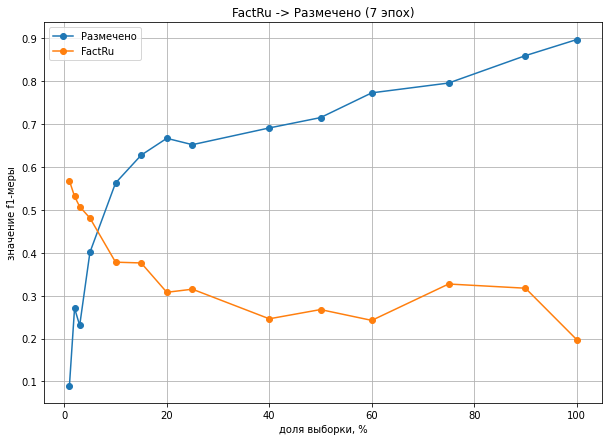

In [36]:
f = plt.figure(figsize=(10, 7)) 
plt.xlabel('доля выборки, %')
plt.ylabel('значение f1-меры')
plt.title('FactRu -> Размечено (7 эпох)')
plt.grid()
plt.plot(train_sizes, f1_razmecheno, label='Размечено', marker='o') 
plt.plot(train_sizes, f1_factru, label='FactRu', marker='o') 
plt.legend() 
plt.show()

In [37]:
f.savefig('factru_razmecheno_7epochs.jpeg')